In [1]:
using Revise

┌ Warning: no Manifest.toml file found, static paths used
└ @ Revise C:\Users\rlipkis\.julia\packages\Revise\9lZUE\src\packagedef.jl:1369


In [2]:
using AdaStress
import AdaStress.BlackBox
using CommonRLInterface
using Plots

┌ Info: Precompiling AdaStress [f8632b6a-8763-4da0-bfaf-5f7707adef25]
└ @ Base loading.jl:1317


## Simulation

In [3]:
using Distributions
using Random

In [4]:
Base.@kwdef mutable struct Walk1D <: AdaStress.BlackBox
    t::Float64=0.0
    t_max::Float64=10.0
    x::Float64=0.0
    x_fail::Float64=10.0
    dist::Normal=Normal(0.0, 1.0)
end

function initialize!(sim::Walk1D)
    sim.t = 0.0
    sim.x = 0.0
end

function update!(sim::Walk1D)
    sim.t += 1.0
    a = rand(sim.dist)
    sim.x += a
    return logpdf(sim.dist, a) - logpdf(sim.dist, 0.0)
end

update! (generic function with 1 method)

In [5]:
AdaStress.reset!(sim::Walk1D) = initialize!(sim)
AdaStress.step!(sim::Walk1D) = update!(sim)
AdaStress.isterminal(sim::Walk1D) = sim.t >= sim.t_max
AdaStress.isevent(sim::Walk1D) = sim.x >= sim.x_fail
AdaStress.distance(sim::Walk1D) = max(sim.x_fail - sim.x, 0.0)

## MCS

In [6]:
mcs = AdaStress.Solvers.MCS(num_steps=10_000)

AdaStress.Solvers.MonteCarloSearch.MCS(10000, 10)

In [7]:
mdp = AdaStress.ASTMDP(Walk1D())
mdp.reward.event_bonus = 100.0

100.0

In [8]:
Random.seed!(0)
sol = mcs(() -> mdp)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


DataStructures.PriorityQueue{Any, Any, Base.Order.ForwardOrdering} with 10 entries:
  UInt32[0xc0ee978b, 0x36ee44f6, 0xcee6e01c, 0xe6ba370e, 0xb0aa5fe3,… => 2.57388
  UInt32[0x83180c7a, 0x1a6c4ece, 0xae0eb1ad, 0xb51faf72, 0x66b86c76,… => 2.58675
  UInt32[0xfa6244f0, 0x63124ef1, 0x1a3f3b57, 0xa9192e7f, 0x21d8ff43,… => 2.60834
  UInt32[0x5c6391b1, 0x1c787839, 0x16eeba79, 0xb31d3074, 0xdbfd2a09,… => 2.64083
  UInt32[0x0a5788b7, 0x2bb518e7, 0x390bc9f6, 0xfc2fd433, 0x4a3cf06e,… => 2.66613
  UInt32[0xc9984325, 0x0a3ce1b8, 0xb490de9d, 0x6d3078a6, 0xa0c84525,… => 2.76545
  UInt32[0x73cc7933, 0x9558ffa6, 0x0addd70e, 0x1bcf4502, 0x212d6e7e,… => 2.83554
  UInt32[0x488430e8, 0x76474d30, 0x725f135d, 0x2c6a13a3, 0x91f4beb6,… => 3.6527
  UInt32[0xd8f490c5, 0xadadd09f, 0x915650eb, 0x89477a2d, 0xd7aa5f01,… => 3.82247
  UInt32[0xb4882912, 0xeaa1eb27, 0xcc73de6e, 0x0365fc77, 0xff48ed4c,… => 101.026

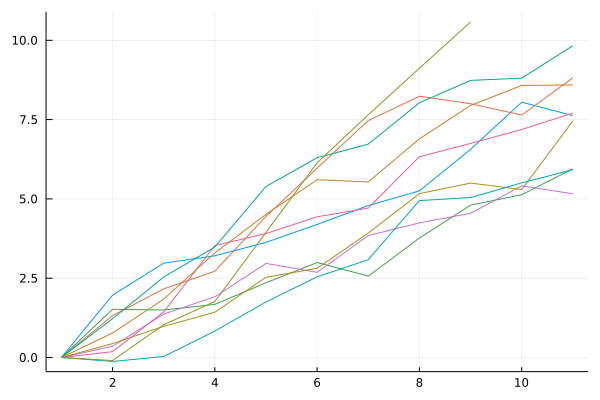

In [9]:
p = plot(legend=false)

for (path, r) in sol
    reset!(mdp)
    x = [mdp.sim.x]
    for a in path
        act!(mdp, a)
        push!(x, mdp.sim.x)
    end
    plot!(p, x)
end
p

## MCTS

In [10]:
mcts = AdaStress.Solvers.MCTS(num_iterations=10_000)

AdaStress.Solvers.MonteCarloTreeSearch.MCTS(10000, 10, 1.0, 0.5, 1.0, nothing)

In [11]:
Random.seed!(0)
sol = mcts(() -> mdp)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


DataStructures.PriorityQueue{Any, Any, Base.Order.ForwardOrdering} with 10 entries:
  UInt32[0x82ec1abd, 0x62719c93, 0x3a2b775d, 0xf83291b4, 0xc83c397d,… => 98.9009
  UInt32[0x82ec1abd, 0x62719c93, 0x3a2b775d, 0xf83291b4, 0xc83c397d,… => 101.523
  UInt32[0x82ec1abd, 0x62719c93, 0x3a2b775d, 0xf83291b4, 0xc83c397d,… => 101.527
  UInt32[0x82ec1abd, 0x62719c93, 0x3a2b775d, 0xf83291b4, 0xc83c397d,… => 101.574
  UInt32[0x82ec1abd, 0x62719c93, 0x3a2b775d, 0xf83291b4, 0xc83c397d,… => 102.882
  UInt32[0x82ec1abd, 0x62719c93, 0x3a2b775d, 0xf83291b4, 0xc83c397d,… => 102.911
  UInt32[0x82ec1abd, 0x62719c93, 0x3a2b775d, 0xf83291b4, 0xc83c397d,… => 199.364
  UInt32[0x82ec1abd, 0x9762a172, 0x4405f27e, 0x63291be0, 0x739584a6,… => 199.588
  UInt32[0x82ec1abd, 0x62719c93, 0x3a2b775d, 0x147fc209, 0x429d9ab2,… => 201.089
  UInt32[0x82ec1abd, 0x62719c93, 0x3a2b775d, 0xf83291b4, 0xc83c397d,… => 201.871

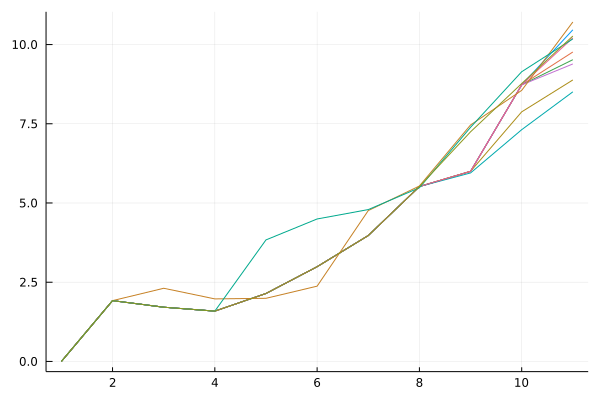

In [12]:
p = plot(legend=false)

for (path, r) in sol
    reset!(mdp)
    x = [mdp.sim.x]
    for a in path
        act!(mdp, a)
        push!(x, mdp.sim.x)
    end
    plot!(p, x)
end
p